## Import dữ liệu và thư viện


In [32]:
import os
import pandas as pd
import requests
from tqdm import tqdm
import re
from unidecode import unidecode
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from urllib.parse import urlsplit, unquote

In [17]:
df = pd.read_csv(r'D:\KLTN_Image-Seaching_Systeam\data\menu.csv')

In [18]:
df

,Tên nhà hàng,Tên món,Giá,Hình ảnh món ăn
0,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Sườn Nướng Tảng Sốt Mật Ong Vừng (1kg),350.000đ,https://mms.img.susercontent.com/vn-11134517-7...
1,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Salad Caeser Với Gà Nướng,100.000đ,https://mms.img.susercontent.com/vn-11134517-7...
2,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Cơm Rang Dứa,115.000đ,https://mms.img.susercontent.com/vn-11134517-7...
3,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Mỳ Ý Sốt Bolognese,115.000đ,https://mms.img.susercontent.com/vn-11134517-7...
4,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Cơm Sườn Nướng Sốt Mật Ong Vừng,150.000đ,https://mms.img.susercontent.com/vn-11134517-7...
...,...,...,...,...
16098,LittleB Kitchen - Coffee & Desert,Cuốn Tomyum,70.000đ,https://mms.img.susercontent.com/vn-11134517-7...
16099,LittleB Kitchen - Coffee & Desert,Cuốn Mix Hai Loại,85.000đ,https://mms.img.susercontent.com/vn-11134517-7...
16100,LittleB Kitchen - Coffee & Desert,Cuốn Mix Ba Loại,85.000đ,https://mms.img.susercontent.com/vn-11134517-7...
16101,LittleB Kitchen - Coffee & Desert,Salad Lườn Ngỗng Sốt Mè Rang,55.000đ,https://mms.img.susercontent.com/vn-11134517-7...


## Khai phá dữ liệu

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tên nhà hàng     16103 non-null  object
 1   Tên món          16103 non-null  object
 2   Giá              16103 non-null  object
 3   Hình ảnh món ăn  16103 non-null  object
dtypes: object(4)
memory usage: 503.3+ KB


In [5]:
len(df['Tên món'].unique())

10966

#### INSIGHT 1 : Tổng quan
* Dữ liệu có 16103 ảnh các món ăn lấy từ sàn web ăn uống foody
* Dữ liệu gồm 10966 tên món khác nhau

In [6]:
def clean_food_name1(name):
    if pd.isna(name):  # Kiểm tra nếu giá trị NaN
        return ""
    
    name = name.lower().strip()  # Chuyển về chữ thường và xóa khoảng trắng thừa
    name = re.sub(r"[^\w\s]", "", name)  # Xóa ký tự đặc biệt
    name = re.sub(r"\s+", " ", name)  # Chuẩn hóa khoảng trắng
    return name
len(df['Tên món'].apply(clean_food_name1).unique())

10166

In [7]:
def clean_food_name2(name):
    if pd.isna(name):  # Kiểm tra nếu giá trị NaN
        return ""
    
    name = name.lower().strip()  # Chuyển về chữ thường và xóa khoảng trắng thừa
    name = unidecode(name)  # Loại bỏ dấu tiếng Việt
    name = re.sub(r"[^\w\s]", "", name)  # Xóa ký tự đặc biệt
    name = re.sub(r"\s+", " ", name)  # Chuẩn hóa khoảng trắng
    return name
len(df['Tên món'].apply(clean_food_name2).unique())

10120

In [8]:
df1=pd.DataFrame(df['Tên món'].apply(clean_food_name1).value_counts())
df1['name']=df1.index 
df1.index = df1.index.to_series().apply(clean_food_name2)
df1

,count,name
Tên món,,
khoai tay chien,44,khoai tây chiên
tra quat,43,trà quất
sua dau nanh,39,sữa đậu nành
tra dao,34,trà đào
tra chanh,33,trà chanh
...,...,...
nhai xanh sua,1,nhài xanh sữa
oc tranhop,1,óc trầnhộp
long thap cam 250grhop khong co bun an kem,1,lòng thập cẩm 250grhộp không có bún ăn kèm


In [9]:
df1['nameclean']=df1.index 
df1[df1['nameclean'].duplicated()]

,count,name,nameclean
Tên món,,,
pho mai que,5,pho mai que,pho mai que
banh trang cuon sot me,3,bánh tráng cuộn sốt me,banh trang cuon sot me
chao thit bam,2,cháo thịt bằm,chao thit bam
nem nuong suat lon flash sale,2,nem nướng suất lớn flash sale,nem nuong suat lon flash sale
pho mai,2,phô mai,pho mai
banh trang cuon sot bo,2,bánh tráng cuốn sốt bơ,banh trang cuon sot bo
com rang dua bo,1,com rang dua bo,com rang dua bo
my xao,1,my xao,my xao
banh trang cuon sot mayonnaise,1,bánh tráng cuộn sốt mayonnaise,banh trang cuon sot mayonnaise


In [10]:
df1[df1['nameclean']=='com tron']

,count,name,nameclean
Tên món,,,
com tron,7,cơm trộn,com tron
com tron,1,com tron,com tron


In [21]:
df['clean_name']=df['Tên món'].apply(clean_food_name2)
df

,Tên nhà hàng,Tên món,Giá,Hình ảnh món ăn,clean_name
0,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Sườn Nướng Tảng Sốt Mật Ong Vừng (1kg),350.000đ,https://mms.img.susercontent.com/vn-11134517-7...,suon nuong tang sot mat ong vung 1kg
1,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Salad Caeser Với Gà Nướng,100.000đ,https://mms.img.susercontent.com/vn-11134517-7...,salad caeser voi ga nuong
2,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Cơm Rang Dứa,115.000đ,https://mms.img.susercontent.com/vn-11134517-7...,com rang dua
3,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Mỳ Ý Sốt Bolognese,115.000đ,https://mms.img.susercontent.com/vn-11134517-7...,my y sot bolognese
4,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Cơm Sườn Nướng Sốt Mật Ong Vừng,150.000đ,https://mms.img.susercontent.com/vn-11134517-7...,com suon nuong sot mat ong vung
...,...,...,...,...,...
16098,LittleB Kitchen - Coffee & Desert,Cuốn Tomyum,70.000đ,https://mms.img.susercontent.com/vn-11134517-7...,cuon tomyum
16099,LittleB Kitchen - Coffee & Desert,Cuốn Mix Hai Loại,85.000đ,https://mms.img.susercontent.com/vn-11134517-7...,cuon mix hai loai
16100,LittleB Kitchen - Coffee & Desert,Cuốn Mix Ba Loại,85.000đ,https://mms.img.susercontent.com/vn-11134517-7...,cuon mix ba loai
16101,LittleB Kitchen - Coffee & Desert,Salad Lườn Ngỗng Sốt Mè Rang,55.000đ,https://mms.img.susercontent.com/vn-11134517-7...,salad luon ngong sot me rang


#### INSIGHT 2: Xử lý cột tên món
* Làm sạch cột dữ liệu tên món bằng:    
    * Chuyển về chữ thường và xóa khoảng trắng thừa
    * Loại bỏ dấu tiếng Việt
    * Xóa ký tự đặc biệt
    * Chuẩn hóa khoảng trắng


Phát hiện có nhiều tên món giống nhau nhưng do các chủ quán không có 1 quy chuẩn cho cách viết nên tạo thành các tên món khác nhau. 
vd: Quán viết dấu quán không viết.

**=> tổng số tên món còn 10120**

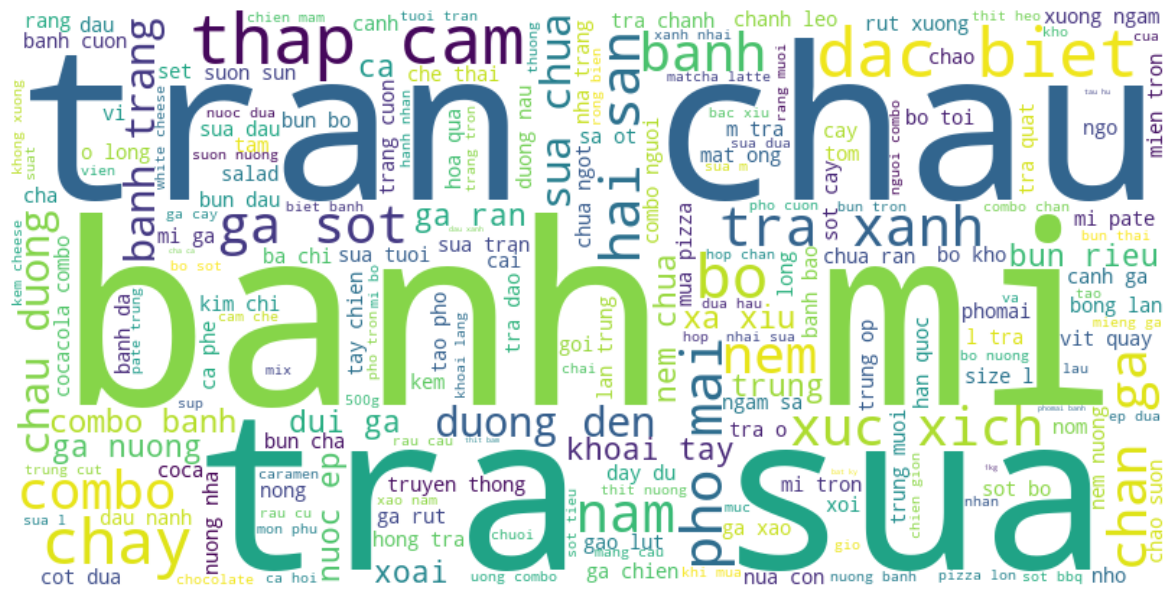

In [13]:
df['tokens'] = df['clean_name'].apply(lambda x: x.split())

# Ghép tất cả các tokens thành một chuỗi
all_tokens = [token for tokens in df['tokens'] for token in tokens]
text = " ".join(all_tokens)

# Tạo word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis'
).generate(text)

# Vẽ word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
# Danh sách từ khóa cần phân tích (có thể mở rộng thêm)
keywords = ['combo', 'day du', 'nguoi', 'dac biet', 'size']

def extract_keywords(name):
    # Trả về danh sách các từ khóa xuất hiện trong tên món
    return [keyword for keyword in keywords if keyword in name]

# Giả sử bạn đã có cột 'clean_name' sau bước tiền xử lý
df['keywords'] = df['clean_name'].apply(extract_keywords)
df_with_keywords = df[df['keywords'].apply(lambda x: len(x) > 0)]
df_with_keywords.shape

(1999, 6)

#### INSIGHT 3 : WordCloud

Các món ăn chính:

* Bánh mì: 
* Bún:
* Gà: 
* Xương, Thịt: 
* Phở cuốn, Nem, Lẩu, Pizza:

Các từ khóa quan trọng:

* Combo: 
* Nướng, Chiên, Sốt: 
* Rau: 
* Ngon, Đầy đủ, Đặc Biệt: 


**-> Wordcloud này thể hiện một thực đơn đa dạng, phong phú nhiều món**

Ở đây có xuất hiện các từ như không phải tên món *'Combo', 'Đặc Biệt','Đầy đủ', 'Ngon'* và các từ chỉ kích thước, *'Size', '2 Người'*: **1999 món** chứa các cụm từ trên

Các từ này không ảnh hưởng đến hệ thông tìn kiếm hình ảnh vì khi trích rút đặc trưng bọn em chỉ trích rút thông tin của ảnh.

In [23]:
vectorizer = TfidfVectorizer() 
X = vectorizer.fit_transform(df['clean_name'])

Số cụm: 2, WCSS: 15644.20, Silhouette Score: 0.009
Số cụm: 3, WCSS: 15479.15, Silhouette Score: 0.012
Số cụm: 4, WCSS: 15261.87, Silhouette Score: 0.018
Số cụm: 5, WCSS: 15123.04, Silhouette Score: 0.021
Số cụm: 6, WCSS: 14986.75, Silhouette Score: 0.024
Số cụm: 7, WCSS: 14875.96, Silhouette Score: 0.027
Số cụm: 8, WCSS: 14866.25, Silhouette Score: 0.024
Số cụm: 9, WCSS: 14745.94, Silhouette Score: 0.026
Số cụm: 10, WCSS: 14626.92, Silhouette Score: 0.030
Số cụm: 11, WCSS: 14561.31, Silhouette Score: 0.030
Số cụm: 12, WCSS: 14506.33, Silhouette Score: 0.030
Số cụm: 13, WCSS: 14420.97, Silhouette Score: 0.033
Số cụm: 14, WCSS: 14344.89, Silhouette Score: 0.036
Số cụm: 15, WCSS: 14292.14, Silhouette Score: 0.037
Số cụm: 16, WCSS: 14211.58, Silhouette Score: 0.038
Số cụm: 17, WCSS: 14150.79, Silhouette Score: 0.039
Số cụm: 18, WCSS: 14028.36, Silhouette Score: 0.042
Số cụm: 19, WCSS: 13981.84, Silhouette Score: 0.043
Số cụm: 20, WCSS: 13915.82, Silhouette Score: 0.044


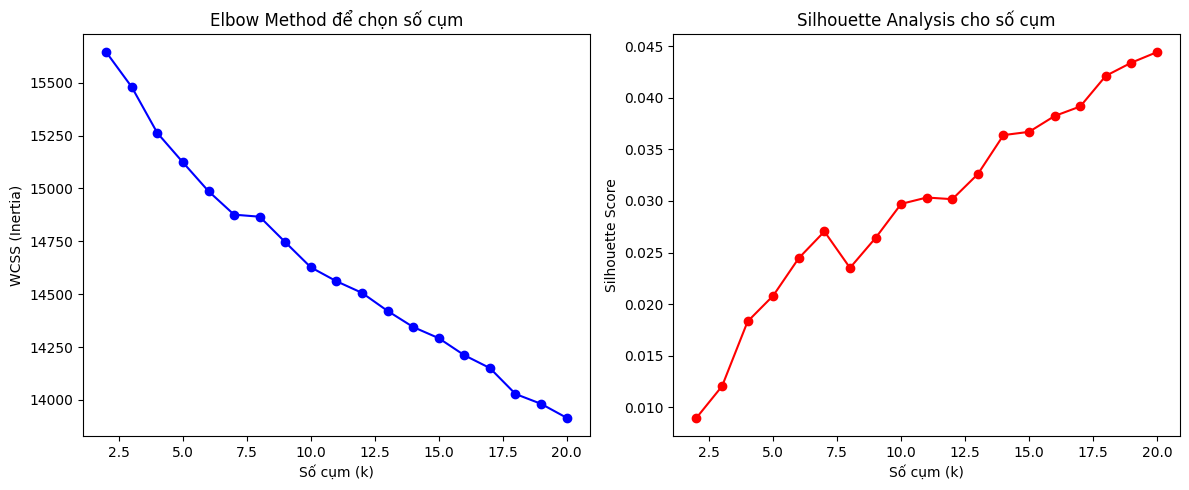

In [24]:


# Giả sử X là ma trận đặc trưng được tính từ TfidfVectorizer của cột clean_name
# Ví dụ: X = vectorizer.fit_transform(df['clean_name'])

# Dải số cụm cần thử (bắt đầu từ 2 vì silhouette không tính cho k=1)
k_range = range(2, 21)

wcss = []  # within-cluster sum of squares (inertia)
silhouette_scores = []  # silhouette score cho từng số cụm

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    inertia = kmeans.inertia_
    wcss.append(inertia)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Số cụm: {k}, WCSS: {inertia:.2f}, Silhouette Score: {silhouette_avg:.3f}")

# Vẽ biểu đồ Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel("Số cụm (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method để chọn số cụm")

# Vẽ biểu đồ Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis cho số cụm")

plt.tight_layout()
plt.show()


In [25]:
num_clusters = 7  # Số cụm, bạn có thể điều chỉnh giá trị này theo nhu cầu
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# In ra một số tên món từ mỗi cụm
for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(df[df['cluster'] == i]['clean_name'].head(10).to_list())
    print("-" * 40)

# Hiển thị các từ khóa nổi bật cho mỗi cụm
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i} top terms: {', '.join(top_terms)}")

Cluster 0:
['suon nuong tang sot mat ong vung 1kg', 'com rang dua', 'my y sot bolognese', 'com suon nuong sot mat ong vung', 'combo 1kg suon nuong tang khoai chien', 'salad xoai', 'com rang dua bo', 'com bo xao can toi', 'chicken pork rib and chorizo paella', 'mixed pork rib seafood']
----------------------------------------
Cluster 1:
['salad caeser voi ga nuong', 'canh ga chien mat ong vung', 'com ga xao pho mai', 'com ga xao nam', 'lau ga ta 12 con', 'lau ga ta 4 nguoi', 'lau ga ta 12 con', 'ga chien popcorn', 'ga white cheese', 'ga popcorn white cheese']
----------------------------------------
Cluster 2:
['banh chuoi', 'banh my bruscheeta sot phomai', 'banh my bruscheeta bo sot bbq', 'banh my bruscheeta sot dau tam', 'banh my bruscheeta sot tieu', 'banh my bruscheeta sot phomai', 'banh my bruscheeta bo sot bbq', 'banh my bruscheeta sot tieu', 'banh my bruscheeta sot chanh leo', 'banh my bruscheeta sot phomai']
----------------------------------------
Cluster 3:
['tra chanh coc', '

Số lượng món trong từng cụm:
cluster
0    9407
1    1579
2    1689
3    1845
4     727
5     402
6     454
Name: count, dtype: int64


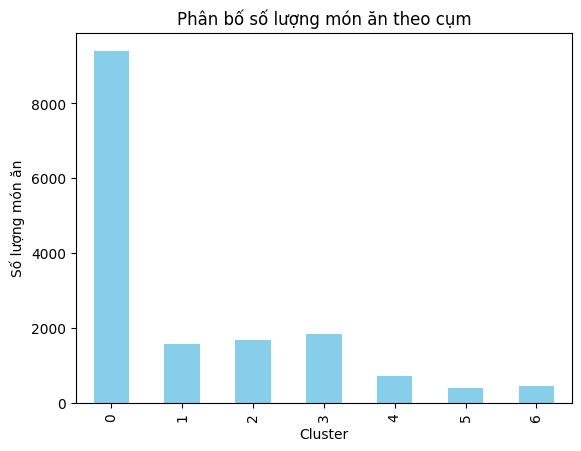

In [27]:
cluster_counts = df['cluster'].value_counts().sort_index()
print("Số lượng món trong từng cụm:")
print(cluster_counts)

# Vẽ biểu đồ để trực quan hóa phân bố các cụm
import matplotlib.pyplot as plt
cluster_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Cluster")
plt.ylabel("Số lượng món ăn")
plt.title("Phân bố số lượng món ăn theo cụm")
plt.show()

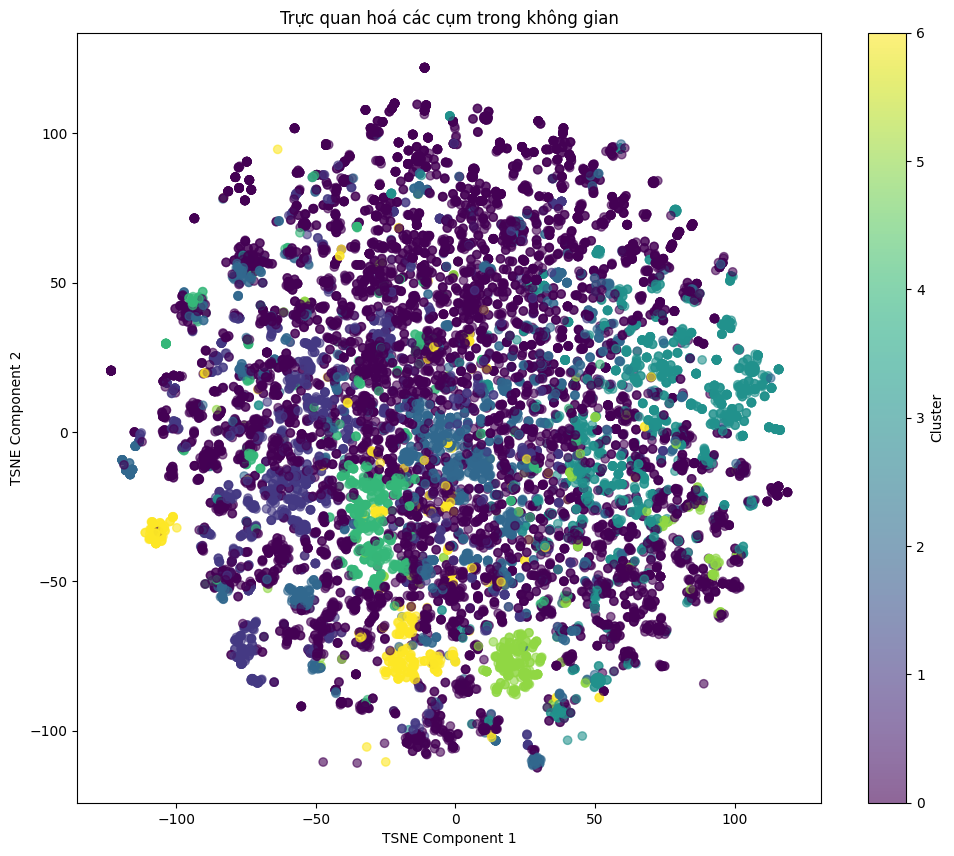

In [ ]:
                                 
# Nếu X là ma trận TF-IDF (sparse matrix), chuyển về dạng dense (nếu kích thước không quá lớn)
X_dense = X.toarray()

# Giảm chiều về 2D bằng t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_dense)

# Vẽ biểu đồ scatter, mỗi điểm được tô màu theo nhãn cluster
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("Trực quan hoá các cụm trong không gian")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()
            

#### INSIGHT 4: TF-IDF + Kmean

##### **Mục đích** của việc Phân nhóm Thông kê và khai thác insight từ phân cụm:

* **Số lượng món trong từng cụm:**
Thống kê số lượng tên món thuộc mỗi cụm giúp bạn nhận biết nhóm món ăn nào phổ biến hay hiếm gặp. Điều này có thể là cơ sở để quyết định ưu tiên hiển thị trong hệ thống tìm kiếm hay gợi ý.
* **Top terms của mỗi cụm:**
Khi in ra các từ khóa nổi bật từ các cụm (dựa trên trọng số của vector trung bình của từng cụm), bạn sẽ thấy được đặc trưng ngữ nghĩa của từng nhóm. Ví dụ, cụm với các từ “pho”, “bo”, “ga” có thể được gán nhãn là nhóm “phở”, từ đó giúp xây dựng taxonomy cho hệ thống.
* **Đánh giá chất lượng phân cụm:**
Các số liệu như WCSS (Within-Cluster Sum of Squares) hay Silhouette Score cho phép bạn đánh giá mức độ phân tách giữa các cụm, từ đó đảm bảo rằng các nhóm được phân chia một cách rõ ràng và hợp lý.

##### **Chọn số cụm**

**Elbow Method:**
* Bạn tính toán WCSS (Within-Cluster Sum of Squares) cho các giá trị k khác nhau (ví dụ từ 2 đến 20).
* Sau đó, vẽ đồ thị WCSS theo số lớp. Điểm mà đường cong WCSS “gãy” (elbow) thường cho biết số lớp tối ưu.
* Ta thấy "elbow" ở k = 7, điều này gợi ý rằng 7 lớp có thể là lựa chọn tốt.

**Silhouette Analysis:**
* Tính điểm Silhouette cho từng giá trị k. Điểm Silhouette cao (gần 1) cho biết các cụm được phân tách rõ ràng.
* Bạn có thể chọn số lớp có điểm Silhouette trung bình cao nhất.
* Ví dụ, ta thấy đồ thị có điểm cực trị là ở k = 7, đó là chỉ số cho thấy 7 lớp tạo nên sự phân chia rõ ràng giữa các nhóm.

**K=7**

In [ ]:
df.info()

,Tên nhà hàng,Tên món,Giá,Hình ảnh món ăn,clean_name,keywords,cluster
0,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Sườn Nướng Tảng Sốt Mật Ong Vừng (1kg),350.000đ,https://mms.img.susercontent.com/vn-11134517-7...,suon nuong tang sot mat ong vung 1kg,[],0
1,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Salad Caeser Với Gà Nướng,100.000đ,https://mms.img.susercontent.com/vn-11134517-7...,salad caeser voi ga nuong,[],1
2,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Cơm Rang Dứa,115.000đ,https://mms.img.susercontent.com/vn-11134517-7...,com rang dua,[],0
3,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Mỳ Ý Sốt Bolognese,115.000đ,https://mms.img.susercontent.com/vn-11134517-7...,my y sot bolognese,[],0
4,Top Floor Rue Des Seaux Restaurant - Hàng Thùng,Cơm Sườn Nướng Sốt Mật Ong Vừng,150.000đ,https://mms.img.susercontent.com/vn-11134517-7...,com suon nuong sot mat ong vung,[],0
...,...,...,...,...,...,...,...
16098,LittleB Kitchen - Coffee & Desert,Cuốn Tomyum,70.000đ,https://mms.img.susercontent.com/vn-11134517-7...,cuon tomyum,[],0
16099,LittleB Kitchen - Coffee & Desert,Cuốn Mix Hai Loại,85.000đ,https://mms.img.susercontent.com/vn-11134517-7...,cuon mix hai loai,[],0
16100,LittleB Kitchen - Coffee & Desert,Cuốn Mix Ba Loại,85.000đ,https://mms.img.susercontent.com/vn-11134517-7...,cuon mix ba loai,[],0
16101,LittleB Kitchen - Coffee & Desert,Salad Lườn Ngỗng Sốt Mè Rang,55.000đ,https://mms.img.susercontent.com/vn-11134517-7...,salad luon ngong sot me rang,[],0


## Download Ảnh 


In [35]:
base_folder = r"D:\KLTN_Image-Seaching_Systeam\data\raw"
if not os.path.exists(base_folder):
    os.makedirs(base_folder)

In [34]:
def get_extension(url):
    """
    Lấy phần mở rộng file từ URL. Nếu không tìm được, trả về '.jpg'
    """
    path = urlsplit(url).path
    _, ext = os.path.splitext(path)
    if ext.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
        return ext
    return '.jpg'
def download_image(url, save_path):
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
            print(f"Downloaded: {save_path}")
        else:
            print(f"Error {response.status_code} while downloading {url}")
    except Exception as e:
        print(f"Exception for {url}: {e}")


In [36]:
for idx, row in df.iterrows():
    dish_name = row['clean_name']
    # Tạo thư mục riêng cho từng món ăn dựa trên tên đã được làm sạch
    dish_folder = os.path.join(base_folder, dish_name)
    if not os.path.exists(dish_folder):
        os.makedirs(dish_folder)
    
    # Nếu cột "Hình ảnh món ăn" chứa nhiều URL được phân tách bởi dấu phẩy
    url_str = row['Hình ảnh món ăn']
    url_list = [u.strip() for u in url_str.split(',') if u.strip() != ""]
    
    for i, url in enumerate(url_list):
        ext = get_extension(url)
        # Tạo tên file dựa trên tên món, index dòng và thứ tự URL trong danh sách
        safe_dish_name = unquote(dish_name).replace(" ", "_")
        filename = f"{safe_dish_name}_{idx}_{i}{ext}"
        save_path = os.path.join(dish_folder, filename)
        download_image(url, save_path)

Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\suon nuong tang sot mat ong vung 1kg\suon_nuong_tang_sot_mat_ong_vung_1kg_0_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\salad caeser voi ga nuong\salad_caeser_voi_ga_nuong_1_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\com rang dua\com_rang_dua_2_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\my y sot bolognese\my_y_sot_bolognese_3_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\com suon nuong sot mat ong vung\com_suon_nuong_sot_mat_ong_vung_4_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\combo 1kg suon nuong tang khoai chien\combo_1kg_suon_nuong_tang_khoai_chien_5_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\salad xoai\salad_xoai_6_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\canh ga chien mat ong vung\canh_ga_chien_mat_ong_vung_7_0.jpg
Downloaded: D:\KLTN_Image-Seaching_Systeam\data\raw\com rang dua bo\com_rang_dua_bo_8_0.jpg
Downloaded: D:\KLTN_Im

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("trolukovich/food11-image-dataset")

print("Path to dataset files:", path)